# M6A Analysis Part 2

In this part we will parse the m6A peak files to compute the m6A peak intensity,
and use the m6A intensities to compute and visualize differential methylated sites.

Pre-requisites:
- Finish running CLAM Snakemake pipeline
- Pre-parsed peak intensities [optional; saves huge time]

In [1]:
# Global variables
PRECOMPUTE = TRUE
SAVE_FIG = TRUE

## Compute m6A peak intensity

### Parse the BAM files

In [2]:
# Use this python script for computing m6A peak intensity
# This takes a long time as it parses all BAM files to 
# count the RPKM for peak windows.
# Alternatively, use the pre-computed files:
# ['input_peak.RPKM.csv', 'IP_peak.RPKM.csv', 'peak_intensity.csv', 'differential_sites_log1.5.csv']
if(! PRECOMPUTE) {
    system("python scripts/parse_peaks.py")
    }
data = read.table('../_data/m6A/peak_intensity_cluster/peak_intensity.csv')
rownames(data) = sapply(strsplit(rownames(data), ":"), function(x) paste0(x[1], ":", paste0(c(x[2],x[3]),collapse="-")))

In [3]:
# a snippet of the data
data[1:3,1:4]
# summary statistics
cat("dim(data)=",dim(data),"\n")
cat("min(data)=",min(data),"\n")
cat("max(data)=",max(data),"\n")

,F_KI_06,F_KI_07,F_KI_08,F_KI_09
chr12:109612940-109613040,1.000000,1.000000,0.2224945,2.497089
chr12:4880532-4880632,3.167406,3.227586,4.9811622,4.567099
chr14:75906737-75906837,2.450675,4.200557,4.5289980,2.684488


dim(data)= 59493 54 
min(data)= 0.01340384 
max(data)= 394.8107 


In [4]:
#write.table(data, file="peak_intensity.tsv", quote=F, sep='\t')

### Unsupervised m6A intensity clustering

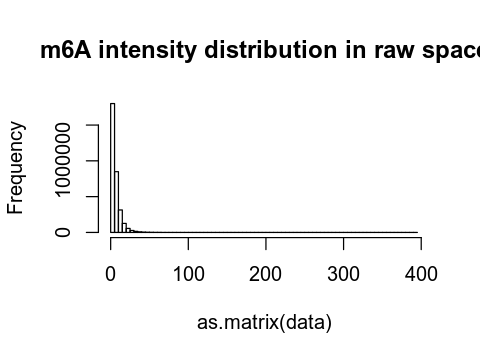

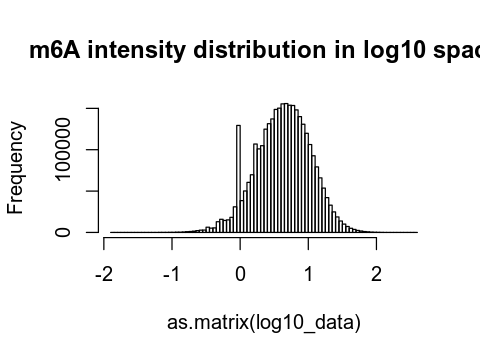

In [5]:
source('scripts/Heatmap.3.R')
library(repr)

log10_data = log10(data)

options(repr.plot.width=4, repr.plot.height=3)
hist(as.matrix(data), breaks=100, main='m6A intensity distribution in raw space')
hist(as.matrix(log10_data), breaks=100, main='m6A intensity distribution in log10 space')

png 
  2

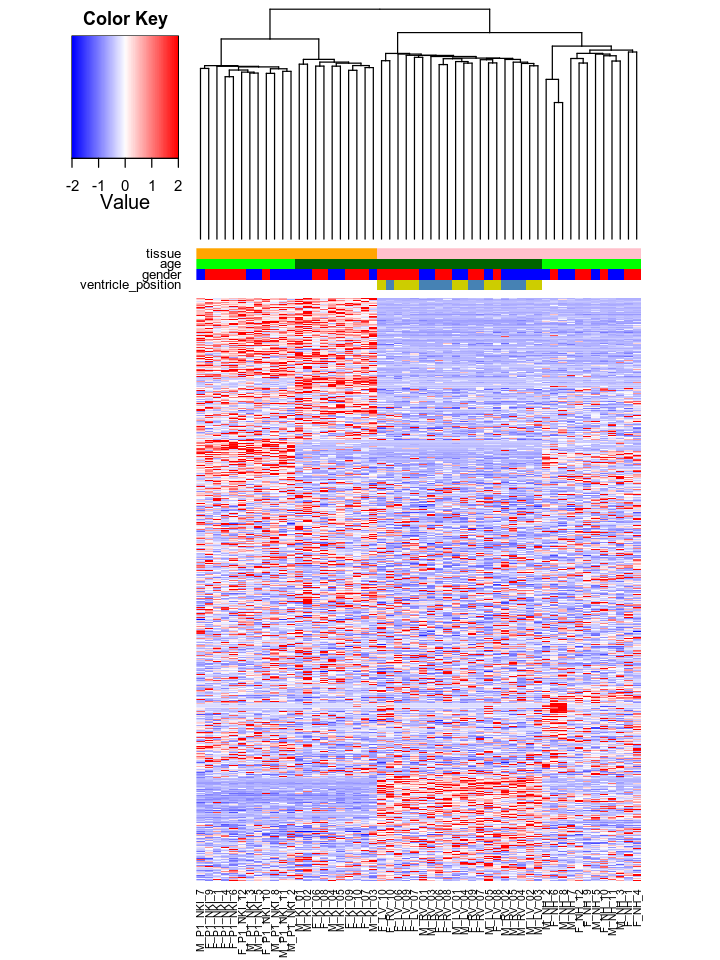

In [6]:
rowVar = apply(log10_data, 1, function(x) var(x)/mean(x))

y = as.matrix(data[order(-rowVar)[1:5000],])
y = t(scale(t(y)))
               
# use 1-correlation as distance metric
hr = hclust(as.dist(1-cor(t(y), method="spearman")), method="average")
#hr = hclust(dist(y), method="average")
hc = hclust(as.dist(1-cor(y, method="pearson")), method="average")
#hc = hclust(dist(t(y)), method="average")


palette <- colorRampPalette(c("blue","white","red"))

clab = data.frame(
    ventricle_position = 'white',
    gender = 'white',
    age = sapply(colnames(y), function(x) ifelse(length(grep('N',x)), 'green', 'darkgreen')),
    tissue = sapply(colnames(y), function(x) ifelse(length(grep('KI',x)), 'orange', 'pink')),
    stringsAsFactors=F
)
clab$gender[ grep('M', colnames(y)) ] = 'blue'
clab$gender[ grep('F', colnames(y)) ] = 'red'
clab$ventricle_position[ grep('RV', colnames(y)) ] = 'steelblue'
clab$ventricle_position[ grep('LV', colnames(y)) ] = 'yellow3'


clab = as.matrix(clab)

breaks = c(seq(-2, 0,length=100),seq(0, 2,length=100))


options(repr.plot.width=6, repr.plot.height=8)
heatmap.3(y, Rowv = as.dendrogram(hr), Colv = as.dendrogram(hc), dendrogram = "col", col = palette, 
        labRow=F, breaks=breaks,
        ColSideColors = clab, key = TRUE)

if(SAVE_FIG) {
    pdf('PeakIntensity_top5000CoV.pdf')
    heatmap.3(y, Rowv = as.dendrogram(hr), Colv = as.dendrogram(hc), dendrogram = "col", col = palette, 
              labRow=F, breaks=breaks,
              ColSideColors = clab, key = TRUE)
    dev.off()
}

### Differential m6A sites detection

This is parsed within the `parse_peaks.py`. 

Differential m6A criteria:
- The maximum peak intensity of all samples >= 2;
- At least 1.5 fold change of peak intensities of the average intensity across samples; 
- Input window RPKM >= 10 in all samples;
- Input gene TPM >= 1 in all samples;
- At least 2 samples in higher peak intensity group must be called as having peak;
- Wilcoxon & t-test between two groups intensities must be significant (<0.05).

## Supervised m6A peaks intensity clustering

Read the list of differential peaks generated by `parse_peak.py`, then plot the heatmaps. 

First read in the data and plot the summary statistics.

png 
  2

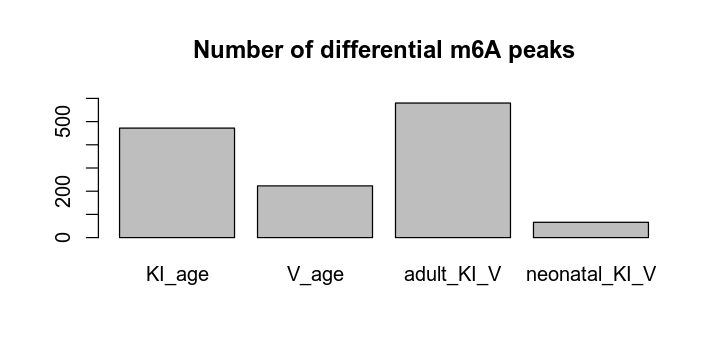

In [7]:
data = read.table('../_data/m6A/parsed_peaks/differential_sites_log1.5.csv', header=T, sep='\t')
if("X"%in%colnames(data))
{
    rownames(data) = data$X
    data = data[,-1]
}
if("url"%in%colnames(data))
{
    data = data[,c(1,2,3,4)]
}
#count = apply(data[,2:7], 2, function(x) length( which( (x>1.5|x<1/1.5) & x!=0 ) ))
count = apply(data, 2, function(x) length( which( (x>0 | x<0 ) )) )

table_count = data.frame(
    compr = colnames(data),
    count = count
    )

options(repr.plot.width=6, repr.plot.height=3)
barplot(table_count$count, names=table_count$compr, 
    ylim=c(0,ceiling(max(table_count$count)/100)*100),
    main='Number of differential m6A peaks')

if(SAVE_FIG) {
    pdf('DiffPeak_summary.pdf')
    barplot(table_count$count, names=table_count$compr, 
        ylim=c(0,ceiling(max(table_count$count)/100)*100),
        main='Number of differential m6A peaks')
    dev.off()

}

Plot the sample clustering based on the differential m6A sites.


Legend:
Column Colour Code:
-    Tissue: orange=Kidney, pink=Heart
-    Age: light green=Neonatal, dark green=Adult
-    Gender: blue=Male, red=Female

Row Colour Code:
-    Blue: neonatal_KI_V: neonatal kidney vs. neonatal heart
-    Orange: KI_age: neonatal kidney vs. adult kidney
-    Red: adult_KI_V: adult kidney vs. adult heart
-    Green: V_age: neonatal heart vs adult heart

png 
  2

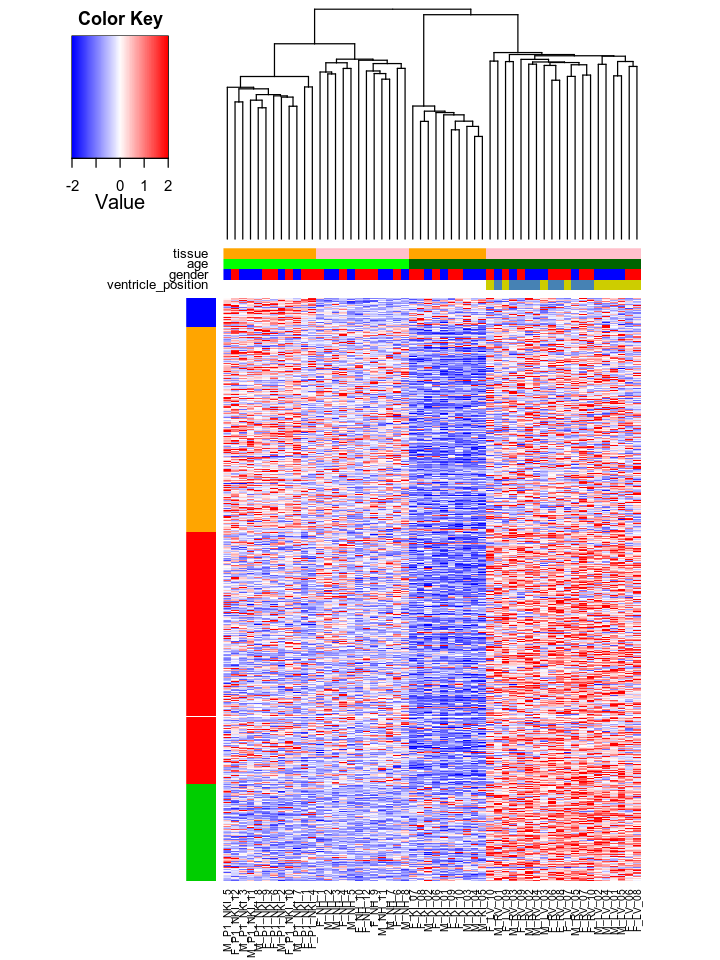

In [8]:
source('scripts/Heatmap.3.R')
data = read.table('../_data/m6A/peak_intensity_cluster/peak_intensity.csv') ## this file has updated gender
differential_sites = read.table('../_data/m6A/parsed_peaks/differential_sites_log1.5.csv', header=T, sep='\t')
if("X"%in%colnames(differential_sites))
{
    rownames(differential_sites) = differential_sites$X
    differential_sites = differential_sites[,-1]
}
if("url"%in%colnames(differential_sites))
{
    differential_sites = differential_sites[,c(1,2,3,4)]
    rownames(differential_sites) = gsub("-", ":", rownames(differential_sites))
}

diff_group = c()
diff_idx = c()
diff_peak = c()
comparison_color_code = c('blue', 'orange', 'red', 'green3')
differential_sites = differential_sites[, c("neonatal_KI_V", "KI_age", "adult_KI_V", "V_age")]
for(j in 1:ncol(differential_sites))
{
	comparison = colnames(differential_sites)[j]
	this_peak = rownames(differential_sites)[differential_sites[,j]!=0]
	diff_group = c(diff_group, rep( comparison_color_code[j], length(this_peak)))
	diff_peak = c(diff_peak, this_peak)
	diff_idx = c(diff_idx, match(this_peak, rownames(data)))

}

diff_df = data.frame(
	group=diff_group,
	peaks=diff_peak,
	idx=diff_idx,
	stringsAsFactors=F)

y = as.matrix(data[diff_df$idx,])
#y = as.matrix(data)
y = t(scale(t(y)))

hr = hclust(as.dist(1-cor(t(y), method="spearman")), method="average")
#hc = hclust(as.dist(1-cor(y, method="pearson")), method="average")
hc = hclust(as.dist(1-cor(y, method="pearson")), method="average")


palette <- colorRampPalette(c("blue","white","red"))

clab = data.frame(
	ventricle_position = 'white',
	gender = 'white',
	age = sapply(colnames(y), function(x) ifelse(length(grep('N',x)), 'green', 'darkgreen')),
	tissue = sapply(colnames(y), function(x) ifelse(length(grep('KI',x)), 'orange', 'pink')),

	stringsAsFactors=F
)
clab$gender[ grep('M', colnames(y)) ] = 'blue'
clab$gender[ grep('F', colnames(y)) ] = 'red'
clab$ventricle_position[ grep('RV', colnames(y)) ] = 'steelblue'
clab$ventricle_position[ grep('LV', colnames(y)) ] = 'yellow3'


clab = as.matrix(clab)
rlab = as.matrix(diff_group, nrow=1)

breaks = c(seq(-2, 0,length=100),seq(0, 2,length=100))

options(repr.plot.width=6, repr.plot.height=8)
heatmap.3(y, Rowv = NULL, Colv = as.dendrogram(hc), dendrogram = "col", 
    col = palette, 
    labRow=F, breaks=breaks,
    ColSideColors = clab, key = TRUE,
    RowSideColors = t(rlab))

if(SAVE_FIG) {
pdf('PeakIntensity_AllDifferential.pdf')
heatmap.3(y, Rowv = NULL, Colv = as.dendrogram(hc), dendrogram = "col", 
    col = palette, 
    labRow=F, breaks=breaks,
    ColSideColors = clab, key = TRUE,
    RowSideColors = t(rlab))
dev.off()
}


### Heatmap on Differential between groups & Topology, Motif

Updated on Nov. 23, 2018: when plotting the differential peaks, also call the external scripts to run the homer script and topology distribution.


#### Neonatal Kidney vs Neonatal Heart

In [9]:
write_BED_peaks = function(peaks, fn)
{
    write.table( gsub("\\.1", "", gsub(":", "\t", peaks)), file=fn, quote=F, row.names=F, col.names=F)
}

png 
  2

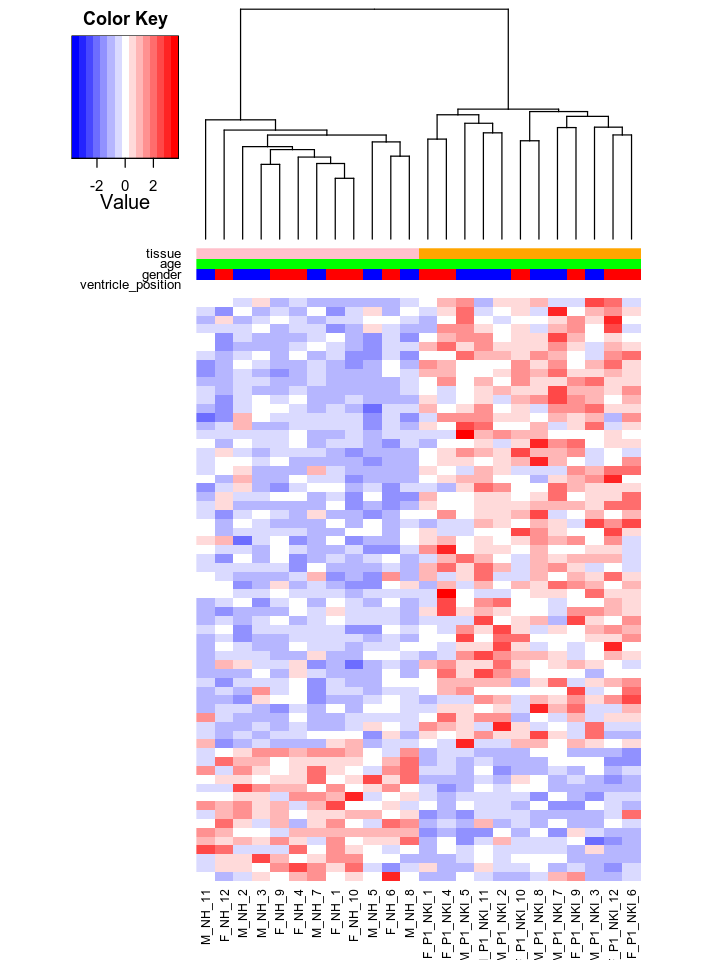

In [10]:
#################################
## neonatal kidney vs ventricle

idx1 = c(21:32, 33:44)
y1 = y[which(diff_group == 'blue'), idx1]
y1 = t(scale(t(y1)))
hc1 = hclust(as.dist(1-cor(y1, method="pearson")), method="average")
hr1 = hclust(as.dist(1-cor(t(y1), method="spearman")), method="average")
clab1 = clab[idx1,]
heatmap.3(y1, Rowv = as.dendrogram(hr1), Colv = as.dendrogram(hc1), dendrogram = "col", 
          col = palette, 
          labRow=F, #breaks=breaks,
          ColSideColors = clab1, key = TRUE)
if(SAVE_FIG) {
    pdf('PeakIntensity_Diff-neonatal_K_V.pdf')
    heatmap.3(y1, Rowv = as.dendrogram(hr1), Colv = as.dendrogram(hc1), dendrogram = "col", 
              col = palette, 
              labRow=F, #breaks=breaks,
              ColSideColors = clab1, key = TRUE)
    dev.off()
}

In [11]:
write_BED_peaks(rownames(y1), "NHK.bed")
system( "bash run.sh NHK.bed _data/DiffPeaks/NHK/" )

#### Neonatal Kideny vs Adult Kidey

png 
  2

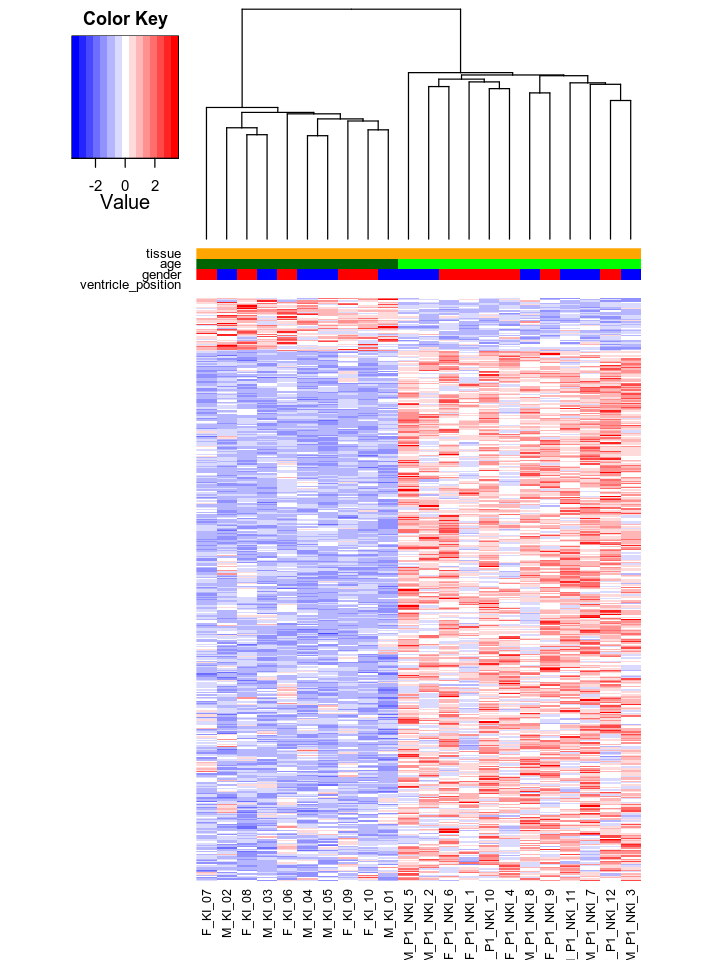

In [12]:
#################################
## neonatal kidney vs adult kidney

idx2 = c(1:5,16:20, 33:44)
y2 = y[which(diff_group == 'orange'), idx2]
y2 = t(scale(t(y2)))
hc2 = hclust(as.dist(1-cor(y2, method="pearson")), method="average")
hr2 = hclust(as.dist(1-cor(t(y2), method="spearman")), method="average")
clab2 = clab[idx2,]
heatmap.3(y2, Rowv = as.dendrogram(hr2), Colv = as.dendrogram(hc2), dendrogram = "col", 
      col = palette, 
      labRow=F, #breaks=breaks,
      ColSideColors = clab2, key = TRUE)
if(SAVE_FIG) {
    pdf('PeakIntensity_Diff-K_age.pdf')
    heatmap.3(y2, Rowv = as.dendrogram(hr2), Colv = as.dendrogram(hc2), dendrogram = "col", 
          col = palette, 
          labRow=F, #breaks=breaks,
          ColSideColors = clab2, key = TRUE)
    dev.off()
}

In [13]:
write_BED_peaks(rownames(y2), "Kidney_Age.bed")
system( "bash run.sh Kidney_Age.bed _data/DiffPeaks/Kidney_Age/" )

#### Adult Kidney vs Adult Heart

png 
  2

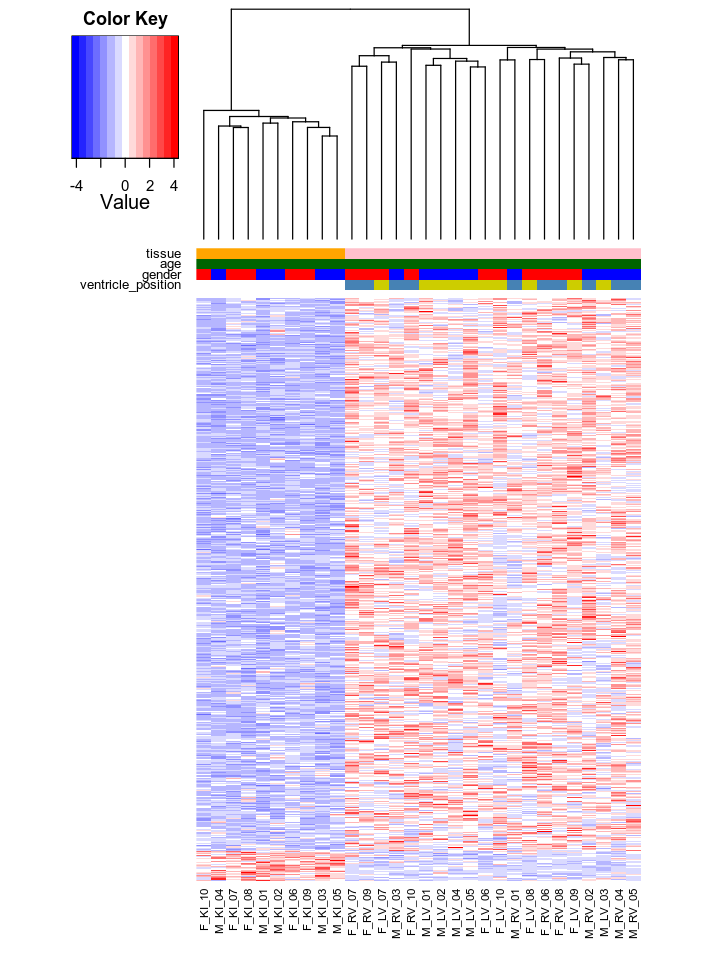

In [14]:
#################################
## adult kidney vs adult heart

idx3 = c(1:5,16:20, 6:15, 45:54)
y3 = y[which(diff_group == 'red'), idx3]
y3 = t(scale(t(y3)))
hr3 = hclust(as.dist(1-cor(t(y3), method="spearman")), method="average")
hc3 = hclust(as.dist(1-cor(y3, method="pearson")), method="average")
clab3 = clab[idx3,]
heatmap.3(y3, Rowv = as.dendrogram(hr3), Colv = as.dendrogram(hc3), dendrogram = "col", 
      col = palette, 
      labRow=F, #breaks=breaks,
      ColSideColors = clab3, key = TRUE)
if(SAVE_FIG) {
    pdf('PeakIntensity_Diff-adult_K_V.pdf')
    heatmap.3(y3, Rowv = as.dendrogram(hr3), Colv = as.dendrogram(hc3), dendrogram = "col", 
          col = palette, 
          labRow=F, #breaks=breaks,
          ColSideColors = clab3, key = TRUE)
    dev.off()
}

In [15]:
write_BED_peaks(rownames(y3), "AHK.bed")
system( "bash run.sh AHK.bed _data/DiffPeaks/AHK/" )

#### Neonatal Heart vs Adult Heart

png 
  2

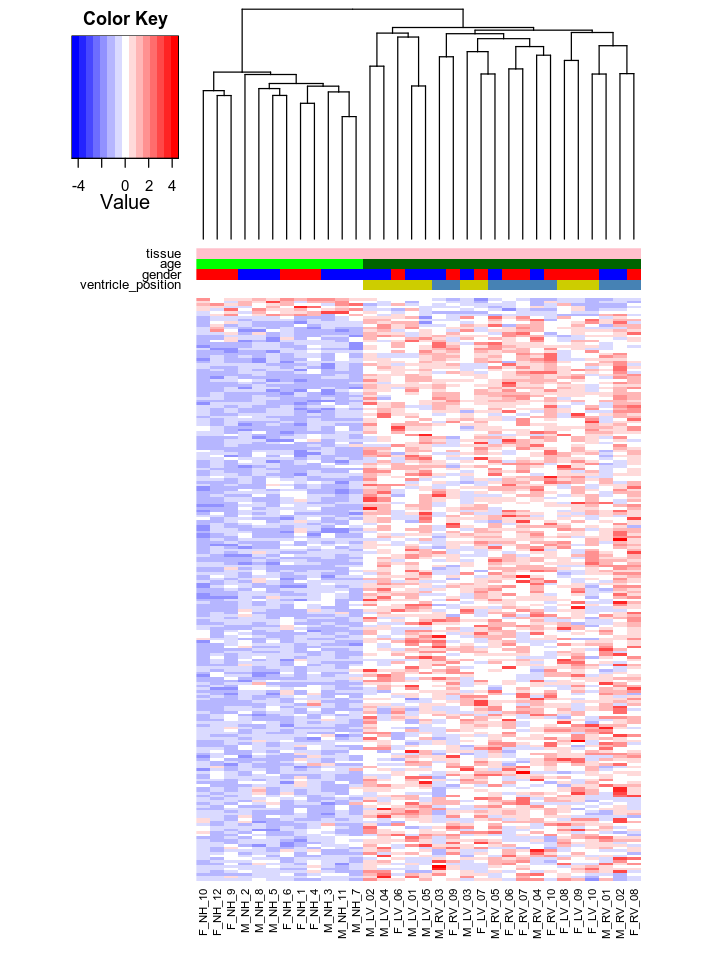

In [16]:
#################################
## neonatal heart vs adult heart

idx4 = c(21:32,6:15, 45:54)
y4 = y[which(diff_group == 'green3'), idx4]
y4 = t(scale(t(y4)))
hr4 = hclust(as.dist(1-cor(t(y4), method="spearman")), method="average")
hc4 = hclust(as.dist(1-cor(y4, method="pearson")), method="average")
clab4 = clab[idx4,]
heatmap.3(y4, Rowv = as.dendrogram(hr4), Colv = as.dendrogram(hc4), dendrogram = "col", 
      col = palette, 
      labRow=F, #breaks=breaks,
      ColSideColors = clab4, key = TRUE)
if(SAVE_FIG) {
    pdf('PeakIntensity_Diff-V_age.pdf')
    heatmap.3(y4, Rowv = as.dendrogram(hr4), Colv = as.dendrogram(hc4), dendrogram = "col", 
          col = palette, 
          labRow=F, #breaks=breaks,
          ColSideColors = clab4, key = TRUE)
    dev.off()
}

In [17]:
write_BED_peaks(rownames(y4), "Heart_Age.bed")
system( "bash run.sh Heart_Age.bed _data/DiffPeaks/Heart_Age/" )